# MLP GAN

Implementation of MLP-GAN on MNIST data

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers.legacy import Adam

from tqdm.notebook import tqdm
from helper_functions import one_hot_encoding, plot_images
import numpy as np
from sys import platform
import os

In [2]:
if tf.test.gpu_device_name():
    print(f'Default GPU Device: {tf.test.gpu_device_name()}')

Default GPU Device: /device:GPU:0


2023-09-18 15:10:09.137220: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-09-18 15:10:09.137238: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-18 15:10:09.137242: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-18 15:10:09.137277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 15:10:09.137297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-18 15:10:09.138132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been buil

In [3]:
# Stop the default logging output
# If you want model summary to be displayed, please disable this.
tf.keras.utils.disable_interactive_logging()

# Set the float pricision to 32bits to reduce memory usage
tf.keras.backend.set_floatx('float32')

In [4]:
# DEFINE SOME GLOBAL VARIABLES
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 128
LATENT_DIMENSION = 150
EPOCH_ITERATIONS = 100
EPOCHS = 250

## Basic MLP GAN

In [5]:
class MLP_GAN:
    def __init__(self, img_width, img_height, img_channel, batch_size, latent_dim, epochs):
        """
            params:
            -------
                * img_width : Width of the image
                * img_height : Height of the image
                * img_channel : Number of image channels
                * batch_size : batch size
                * latent_dim : dimension of the latent vector
                * epochs : number of epochs
            returns:
            --------
                * MLP GAN Object
        """
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.img_shape = (img_width, img_height, img_channel)
        self.epochs = epochs
        self.digit_encoding = one_hot_encoding()

        ######################################
        #   Define the Computational Graph   #
        ######################################
        self.gen = self.__build_generator()
        self.discrim = self.__build_discriminator()

        self.generator_loss_history, self.discriminator_loss_history = [], []
        self.discrim.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.4), metrics=['accuracy'])
        
        self.discrim.trainable = False
        
        inp = Input(shape=self.latent_dim, name="latent")
        gen_out = self.gen(inp)
        
        # feed into discriminator
        discrim_out = self.discrim(gen_out)
        self.combined = Model(inp, discrim_out, name="combined_model")
        self.combined.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.4), metrics=['accuracy'])
    
    def train(self):
        """
            Training Function which loads the data & trains the model
        """

        ## LOAD the data
        (x_train, y_train), (_, _) = mnist.load_data()
        x_train = (x_train.astype(np.float32) - 127.5) / 127.5
        half_batch = int(self.batch_size/2)

        # FOR EACH EPOCH we'll train on EPOCH_ITERATIONS*BATCH_SIZE data points
        for epoch in tqdm(range(1, self.epochs + 1)):
            for i in range(EPOCH_ITERATIONS):
                # select some random images (batch_size)
                idx = np.random.randint(0, x_train.shape[0], half_batch)
                imgs = np.reshape(x_train[idx], (-1, np.prod(self.img_shape)))
                
                ### LABEL (True : Real Images)
                y_imgs = np.ones(half_batch)

                # Noise to be fed into generator
                rand_noise = np.random.normal(0, 1, (half_batch, self.latent_dim))

                # Generate fake images using the noise
                
                gen_imgs = self.gen.predict([rand_noise])
                ### LABEL (False : Fake Images)
                y_gen_imgs = np.zeros(half_batch)

                # COMBINE THE FAKE AND REAL IMAGES
                imgs = np.concatenate([imgs, gen_imgs])
                y_imgs = np.concatenate([y_imgs, y_gen_imgs])
                
                # Shuffle
                indices = np.arange(self.batch_size)
                np.random.shuffle(indices)
                
                imgs = imgs[indices]
                y_imgs = y_imgs[indices]

                # Disciminator loss
                d_loss = self.discrim.train_on_batch(imgs, y_imgs)
                
                if i-EPOCH_ITERATIONS == -1:
                    # Store on loss on the last iteration
                    self.discriminator_loss_history.append(d_loss)
            
            for i in range(EPOCH_ITERATIONS):
                # Noise to be fed into generator
                rand_noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                y_gen_imgs = np.ones(self.batch_size)

                # Train the generator
                g_loss = self.combined.train_on_batch(rand_noise, y_gen_imgs)
                if i-EPOCH_ITERATIONS == -1:
                    # Store on loss on the last iteration
                    self.generator_loss_history.append(g_loss)
            
            if epoch % 50 == 0:
                # Generate some images during the training phase
                print(f"############################## EPOCH : {epoch} ##############################")
                generated_images = self.generate_some_imgs()
                img_arr = np.reshape(generated_images, (-1,)+self.img_shape[:2])
                plot_images(2, 5, (9, 5), img_arr, [], cmap = 'gray')
                
    ############ CLASS HELPER FUNCTIONS ############
    def get_losses(self):
        """
            returns the loss values
        """
        return self.generator_loss_history, self.discriminator_loss_history
    
    def generate_some_imgs(self, num = 10):
        """
            Helper function to generate some images.
        """
        rand_noise = np.random.normal(0, 1, (num, self.latent_dim))
        return self.gen.predict([rand_noise])
    
    def get_summary(self):
        """
            Helper function to generate some model summary.
        """
        self.combined.summary()

    def __build_discriminator(self):
        """
            Internal helper function to build the discriminator.
        """
        discriminator = Sequential([
            Dense(1024, input_dim = np.prod(self.img_shape)),
            LeakyReLU(alpha=0.2),
            Dropout(0.2),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dropout(0.2),
            Dense(256),
            LeakyReLU(alpha=0.2),
            Dropout(0.1),
            Dense(1, activation = 'sigmoid')
        ], name = 'Discriminator')
        return discriminator
    
    def __build_generator(self):
        """
            Internal helper function to build the generator.
        """
        # LATENT DIMENTION WILL BE BUILT ON THE RANDOM NOISE
        generator = Sequential([
            Dense(256, input_dim = self.latent_dim),
            LeakyReLU(alpha=0.2),
            Dropout(0.2),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(np.prod(self.img_shape), activation = 'tanh')
        ], name = 'Generator')
        return generator

In [6]:
mGAN = MLP_GAN(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS, BATCH_SIZE, LATENT_DIMENSION, EPOCHS)

2023-09-18 15:10:09.224573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-18 15:10:09.224591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


  0%|          | 0/250 [00:00<?, ?it/s]

2023-09-18 15:10:09.587772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:10:09.776597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-18 15:10:13.381696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


############################## EPOCH : 50 ##############################


2023-09-18 15:13:30.724608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


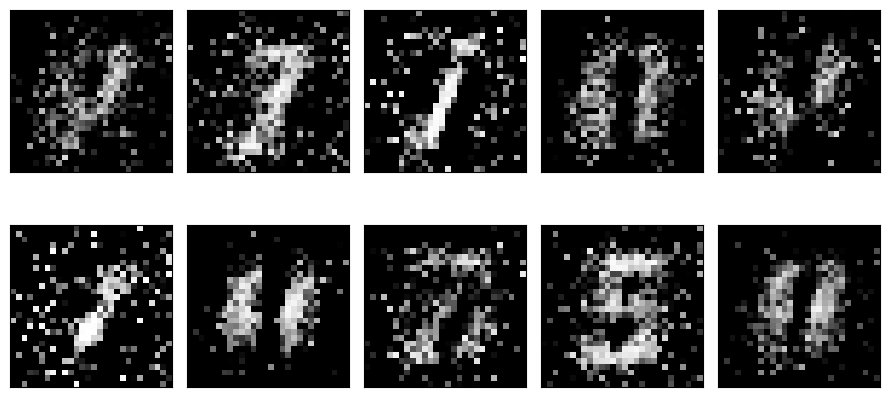

############################## EPOCH : 100 ##############################


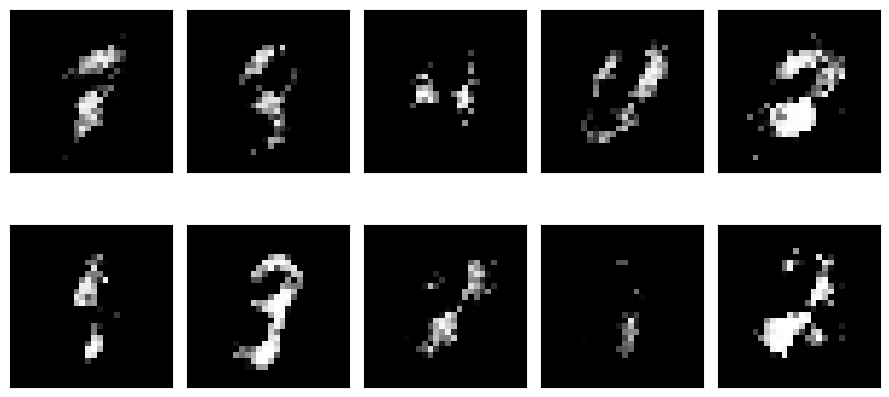

############################## EPOCH : 150 ##############################


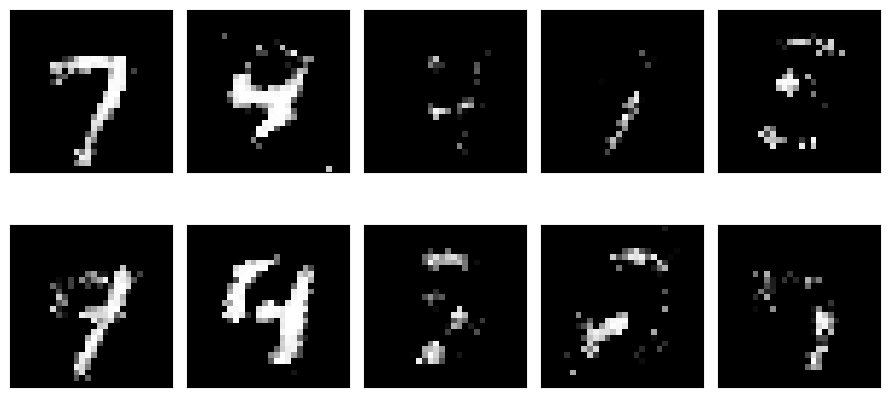

############################## EPOCH : 200 ##############################


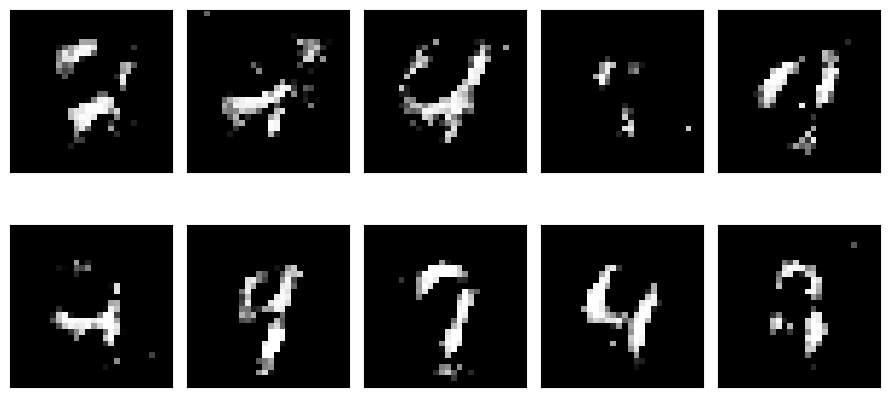

############################## EPOCH : 250 ##############################


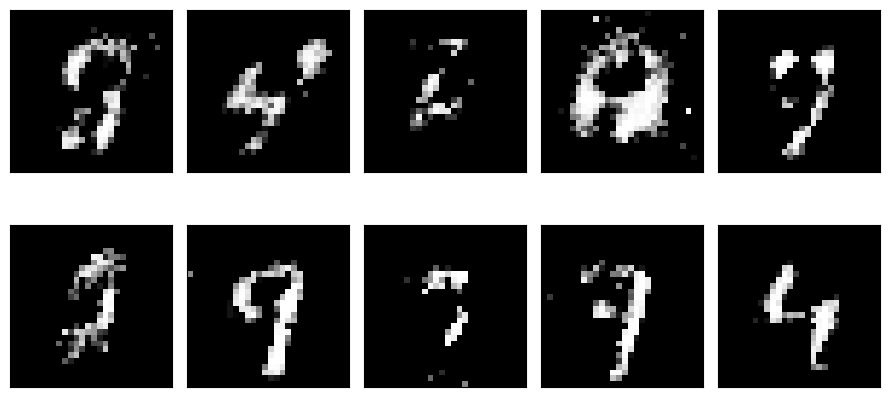

In [7]:
mGAN.train()

In [8]:
if platform == "darwin":
    os.system("say 'Model Training DONE!'")

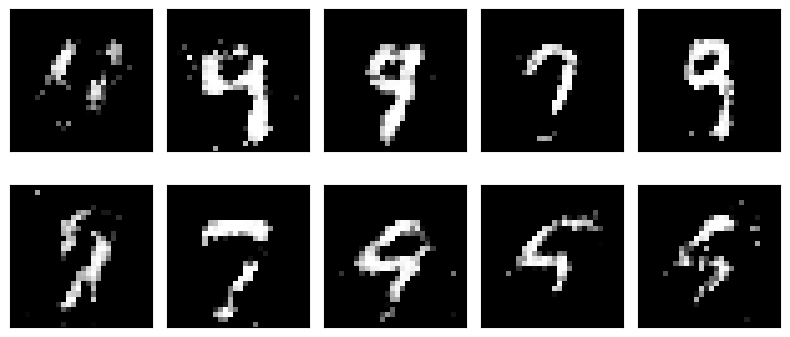

In [19]:
generated_images = mGAN.generate_some_imgs()
img_arr = np.reshape(generated_images, (-1,)+(IMAGE_WIDTH, IMAGE_HEIGHT))
plot_images(2, 5, (8, 4), img_arr, [], cmap='gray')